In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
import pandas as pd

In [3]:
import mlflow
from azureml.core import Workspace

In [4]:
ws = Workspace.from_config(path='../../ML')
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [5]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1
label = 'WindSlab_Likelihood'
file_label = 'co_WindSlab_Likelihood_small'
exp_signifier = ''
train_test_split = 5000
num_y = 1000

In [6]:
mlflow.set_experiment(file_label+exp_signifier)

INFO: 'co_WindSlab_Likelihood_small' does not exist. Creating a new experiment


In [7]:
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'

In [8]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:5000,feature,:])
def calculate_feature_std(feature):
    print('On feature: ' + str(feature))
    return np.nanstd(X[0:5000,feature,:])

In [9]:
X = np.load(ml_path + '/Xtrain_batch_0_' + file_label + '_on_disk.npy', mmap_mode='r')

In [10]:
feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))
feature_std = Parallel(n_jobs=4)(map(delayed(calculate_feature_std), range(0,num_features)))

In [11]:
#feature_means = np.load(means_fn)
#feature_std = np.load(std_fn)

In [12]:
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [13]:
mlflow.log_param('TrainSamples', len(X))

In [14]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_y_batches = 1
num_y_train_files_per_batch = 1
num_y_test_batches = 1
num_y_test_files_per_batch = 1


y_df = None
for i in range(0, num_y_batches):
    for j in range(0, num_y_train_files_per_batch):        
        df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  
        y_df = pd.concat([y_df, df])

for i in range(0, num_y_test_batches):
    for j in range(0, num_y_test_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
        y_df = pd.concat([y_df, df])

y_df = y_df.reset_index(drop=True)

In [15]:
categories = list(y_df[label].unique())
categories.sort()

In [16]:
categories

['0-unlikely', '1-possible', '2-likely', '3-very likely', 'no-data']

In [17]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=categories, ordered=True)
y_df[label + '_Cat'] = y_df[label].astype(cat_type)
y = y_df[label + '_Cat'].cat.codes.values
dict( enumerate(y_df[label + '_Cat'].cat.categories ) )

{0: '0-unlikely',
 1: '1-possible',
 2: '2-likely',
 3: '3-very likely',
 4: 'no-data'}

In [18]:
y_df.shape

(6000, 303)

In [19]:
y_df.groupby(['season', label]).count()

sample  latitude  longitude  UnifiedRegion  \
season WindSlab_Likelihood                                               
15-16  0-unlikely              101       101        101            101   
       1-possible              369       369        369            369   
       2-likely                733       733        733            733   
       no-data                 462       462        462            462   
16-17  0-unlikely              170       170        170            170   
       1-possible              465       465        465            465   
       2-likely                291       291        291            291   
       3-very likely            23        23         23             23   
       no-data                 395       395        395            395   
17-18  0-unlikely              377       377        377            377   
       1-possible              594       594        594            594   
       2-likely                405       405        405            405   
       3-very likely            48        48         48             48   
       no-data                 567       567        567            567   
18-19  1-possible              332       332        332            332   
       2-likely                334       334        334            334   
       no-data                 334       334        334            334   

                            UnifiedRegionleft  Unnamed: 0  BottomLineSummary  \
season WindSlab_Likelihood                                                     
15-16  0-unlikely                         101         101                101   
       1-possible                         369         369                369   
       2-likely                           733         733                733   
       no-data                            462         462                462   
16-17  0-unlikely                         170         170                170   
       1-possible                         465         465                465   
       2-likely                           291         291                291   
       3-very likely                       23          23                 23   
       no-data                            395         395                395   
17-18  0-unlikely                         377         377                377   
       1-possible                         594         594                594   
       2-likely                           405         405                405   
       3-very likely                       48          48                 48   
       no-data                            567         567                567   
18-19  1-possible                         332         332                117   
       2-likely                           334         334                 47   
       no-data                            334         334                115   

                            Cornices_Likelihood  Cornices_MaximumSize  \
season WindSlab_Likelihood                                              
15-16  0-unlikely                           101                   101   
       1-possible                           369                   369   
       2-likely                             733                   733   
       no-data                              462                   462   
16-17  0-unlikely                           170                   170   
       1-possible                           465                   465   
       2-likely                             291                   291   
       3-very likely                         23                    23   
       no-data                              395                   395   
17-18  0-unlikely                           377                   377   
       1-possible                           594                   594   
       2-likely                             405                   405   
       3-very likely                         48                    48   
     

In [20]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap

#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_y)]).shuffle())

In [21]:
splits_2

((#5000) [3447,3374,4587,1837,1533,1757,2227,1616,3308,4467...],
 (#1000) [5454,5288,5509,5276,5814,5613,5101,5179,5037,5879...])

In [22]:
top_features = pd.read_csv('FeatureImportances.csv', index_col=0)

In [23]:
feature_means = (np.nan_to_num(feature_means))
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [24]:
orig_X = X
orig_feature_means = feature_means
orig_feature_std = feature_std

In [25]:
num_epochs = 5
learning_rate = 1e-2

In [26]:
#method to standardize each batch while also replacing any nans with the mean value before standarization
class TSStandardizeNanMeanReplaceNan(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
       
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [27]:
feature_means

array([ 8.41041910e-05,  1.22705969e-04,  4.57533388e-05,  9.70988476e-05,
        1.12267648e-04,  8.23423543e-05,  9.70947658e-05,  1.06226100e-04,
        8.83968896e-05,  1.02406411e-04,  1.25780643e-04,  7.99468544e-05,
        1.03907827e-04,  1.41502489e-04,  6.90644883e-05,  9.20473176e-05,
        9.89021937e-05,  8.55074541e-05,  9.91445268e-05,  1.55206217e-04,
        5.13963896e-05,  9.55999349e-05,  1.65871810e-04,  3.86405009e-05,
        8.97246209e-05,  9.54143834e-05,  8.40696157e-05,  9.29432936e-05,
        1.69077830e-04,  3.33695061e-05,  9.09947339e-05,  1.65489095e-04,
        3.20600157e-05,  8.88873983e-05,  1.58196155e-04,  3.14429963e-05,
        8.58185740e-05,  1.50679349e-04,  2.97807346e-05,  8.98610160e-05,
        9.79244942e-05,  8.19737252e-05,  8.11809150e-05,  1.45106111e-04,
        2.38715038e-05,  7.62101845e-05,  1.49915912e-04,  6.51381015e-06,
        6.99067823e-05,  1.50957087e-04, -9.18487785e-06,  6.93880502e-05,
        1.41741228e-04, -

In [28]:
def log_mlflow_metrics(recorder):
    for i in enumerate(recorder.metric_names):
        if i[0] == 0:
            continue
        elif i[0] == len(recorder.metric_names)-1:
            continue
        for r in range(len(recorder.values)):            
            mlflow.log_metric(i[1], recorder.values[r][i[0]-1])

In [32]:
tfms = [None, [Categorize()]]
def run_experiment(num_lookback, num_f, nf=32, ks=40, bottleneck=True, return_learner = False, plot_matrix=False):
    with mlflow.start_run():
        feature_filter = top_features[:num_f].index
        if num_f == num_features:
            X = orig_X[:, :, -1*num_lookback:]
        else:
            X = orig_X[:, feature_filter, -1*num_lookback:]
        global feature_means, feature_std
        feature_means = orig_feature_means[feature_filter]
        feature_std = orig_feature_std[feature_filter]
        mlflow.log_param('num_features', num_f)
        mlflow.log_param('num_lookback', num_lookback)
        mlflow.log_metric('num_features', num_f)
        mlflow.log_metric('num_lookback', num_lookback)
        mlflow.log_metric('num_filters', nf)
        mlflow.log_metric('kernel_size', ks)
        mlflow.log_metric('bottleneck', int(bottleneck))
        
        print('On lookback: ' + str(num_lookback) + ' features: ' + str(num_f) + ' nf: ' + str(nf) + ' ks: ' + str(ks) + ' bottleneck: ' + str(bottleneck))
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)
        dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan()], num_workers=0)
      
        model = InceptionTime(dls.vars, dls.c, nf=nf, ks=ks, bottleneck=bottleneck)            
        learn = Learner(dls, model, metrics=accuracy)
        learn.fit_one_cycle(num_epochs, lr_max=learning_rate)
        log_mlflow_metrics(learn.recorder)
        interp = ClassificationInterpretation.from_learner(learn)
        if plot_matrix:            
            conf_matrix = interp.plot_confusion_matrix(normalize=True)
        cm = interp.confusion_matrix()
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for r in range(len(cm)):
            for c in range(len(cm[r])):
                mlflow.log_metric('Actual ' + str(r) + ' Predicted ' + str(c), cm[r,c])

        d,t = flatten_check(interp.decoded, interp.targs)
        mlflow.log_metric('Test Accuracy', skm.accuracy_score(t, d))
        mlflow.end_run()
        if return_learner:
            return learn
        del model, dsets, dls, learn

In [30]:
mlflow.end_run()

On lookback: 7 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.025304,1.747375,0.408000,00:02
1,0.879865,1.621038,0.417000,00:02
2,0.701380,1.854580,0.390000,00:02
3,0.553887,2.161361,0.361000,00:02


On lookback: 7 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.806458,2.010972,0.450000,00:05
1,0.654204,1.775898,0.409000,00:05
2,0.505643,2.005590,0.393000,00:05
3,0.374993,2.342717,0.401000,00:05


On lookback: 7 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.808163,1.685786,0.429000,00:07
1,0.651304,1.628771,0.436000,00:07
2,0.505105,1.775688,0.429000,00:07
3,0.357213,2.010410,0.402000,00:07


On lookback: 7 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.801202,1.358274,0.469000,00:10
1,0.648614,1.557050,0.432000,00:09
2,0.484701,1.834133,0.433000,00:09
3,0.341152,2.102446,0.436000,00:10


On lookback: 7 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.767907,1.633658,0.467000,00:12
1,0.624457,1.401200,0.491000,00:12
2,0.470205,1.796492,0.449000,00:12
3,0.341592,1.921334,0.427000,00:12


On lookback: 7 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.748320,1.462893,0.437000,00:14
1,0.602898,1.384350,0.469000,00:14
2,0.453548,1.667055,0.451000,00:14
3,0.337212,1.876408,0.459000,00:14


On lookback: 7 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.720478,1.319500,0.556000,00:16
1,0.575543,1.410417,0.472000,00:16
2,0.443340,1.589358,0.491000,00:16
3,0.319452,1.757873,0.465000,00:17


On lookback: 30 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.964085,3.379098,0.311000,00:03
1,0.777040,4.098617,0.365000,00:02
2,0.615252,3.385809,0.399000,00:02
3,0.461768,3.358016,0.367000,00:02


On lookback: 30 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.875144,2.374168,0.402000,00:05
1,0.658133,3.316363,0.364000,00:05
2,0.501312,2.179710,0.377000,00:05
3,0.364541,2.923689,0.372000,00:05


On lookback: 30 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.871402,4.948870,0.349000,00:07
1,0.671749,2.165100,0.469000,00:07
2,0.496307,2.937712,0.397000,00:07
3,0.366814,2.715303,0.431000,00:07


On lookback: 30 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.893554,3.573412,0.387000,00:10
1,0.673058,3.788924,0.372000,00:10
2,0.513925,2.544688,0.424000,00:10
3,0.389534,2.596765,0.420000,00:10


On lookback: 30 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.859911,3.375633,0.396000,00:12
1,0.670019,3.814117,0.406000,00:12
2,0.498633,2.262151,0.433000,00:12
3,0.367807,2.480597,0.413000,00:12


On lookback: 30 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.833672,2.984086,0.375000,00:14
1,0.640391,2.781656,0.407000,00:14
2,0.492933,2.523407,0.466000,00:14
3,0.379138,2.611940,0.432000,00:14


On lookback: 30 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.843016,2.925429,0.437000,00:17
1,0.619513,2.953810,0.418000,00:17
2,0.479540,2.649567,0.408000,00:17
3,0.364336,2.722157,0.412000,00:16


On lookback: 60 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.035908,2.160767,0.301000,00:03
1,0.853957,2.869453,0.328000,00:02
2,0.687465,2.885517,0.364000,00:02
3,0.544750,3.312511,0.360000,00:02


On lookback: 60 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.047048,5.260388,0.274000,00:05
1,0.772130,2.730195,0.362000,00:05
2,0.573790,2.665339,0.325000,00:05
3,0.436787,3.004657,0.365000,00:05


On lookback: 60 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.092968,3.062320,0.345000,00:08
1,0.773525,3.754935,0.419000,00:07
2,0.578894,2.632703,0.395000,00:07
3,0.424124,2.946496,0.385000,00:07


On lookback: 60 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.067700,1.765879,0.364000,00:10
1,0.775272,1.721074,0.420000,00:10
2,0.560263,2.303474,0.398000,00:10
3,0.434816,2.531761,0.396000,00:10


On lookback: 60 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.013076,1.857855,0.398000,00:12
1,0.730257,2.319624,0.460000,00:12
2,0.563224,2.451087,0.398000,00:12
3,0.446677,2.475621,0.401000,00:12


On lookback: 60 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.062518,2.886869,0.357000,00:15
1,0.735317,1.302690,0.491000,00:14
2,0.544655,2.418811,0.455000,00:14
3,0.419018,2.133490,0.443000,00:14


On lookback: 60 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.891144,3.221277,0.380000,00:17
1,0.651084,2.000519,0.455000,00:17
2,0.509790,1.705728,0.481000,00:17
3,0.396277,1.923122,0.446000,00:17


/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/interpret.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**kwargs)


On lookback: 90 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.134189,10.998183,0.372000,00:03
1,0.935874,2.802127,0.323000,00:02
2,0.775839,3.061083,0.349000,00:02
3,0.607118,3.048684,0.328000,00:02


On lookback: 90 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.167836,4.254881,0.251000,00:05
1,0.987269,1.865357,0.309000,00:05
2,0.689535,3.224896,0.358000,00:05
3,0.537349,2.830057,0.355000,00:05


On lookback: 90 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.161900,4.591733,0.310000,00:08
1,0.942772,2.329080,0.402000,00:07
2,0.687775,2.784122,0.394000,00:07
3,0.516220,2.724815,0.385000,00:07


On lookback: 90 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.145479,5.108428,0.344000,00:10
1,0.916060,2.921039,0.348000,00:10
2,0.681898,2.672167,0.348000,00:10
3,0.513856,2.745127,0.387000,00:10


On lookback: 90 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.134652,2.388952,0.352000,00:12
1,0.871137,5.349257,0.368000,00:12
2,0.650880,2.402123,0.423000,00:12
3,0.497138,2.360688,0.403000,00:12


On lookback: 90 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.165597,1.703915,0.320000,00:15
1,0.946498,2.363173,0.372000,00:15
2,0.663532,2.007442,0.414000,00:14
3,0.504064,2.046407,0.418000,00:14


On lookback: 90 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.000607,1.986029,0.393000,00:17
1,0.729944,1.830750,0.479000,00:17
2,0.542718,1.899850,0.474000,00:17
3,0.426721,1.993033,0.490000,00:17


On lookback: 120 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.132227,2.408588,0.204000,00:03
1,0.928373,2.432140,0.237000,00:03
2,0.752934,2.925474,0.281000,00:03
3,0.609662,2.782632,0.297000,00:03


On lookback: 120 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.190536,2.642434,0.263000,00:05
1,0.890338,3.194111,0.364000,00:05
2,0.660360,2.937651,0.406000,00:05
3,0.502780,2.847538,0.412000,00:05


On lookback: 120 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.184110,4.571033,0.336000,00:08
1,0.884611,2.261629,0.380000,00:08
2,0.649361,2.809505,0.425000,00:07
3,0.504889,2.523863,0.411000,00:08


On lookback: 120 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.142048,1.847181,0.330000,00:10
1,0.844902,2.147106,0.429000,00:10
2,0.626402,2.721295,0.430000,00:10
3,0.475748,2.949184,0.430000,00:10


On lookback: 120 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.204336,2.193761,0.373000,00:12
1,0.925893,2.030416,0.427000,00:12
2,0.664360,1.591365,0.467000,00:12
3,0.504564,2.220847,0.442000,00:13


On lookback: 120 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.163587,5.866695,0.269000,00:15
1,0.859245,2.462427,0.430000,00:15
2,0.639980,2.177828,0.453000,00:14
3,0.500805,2.149082,0.466000,00:15


On lookback: 120 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.105735,3.635967,0.360000,00:17
1,0.765199,2.027313,0.474000,00:16
2,0.589179,1.648324,0.518000,00:17
3,0.469214,1.931487,0.508000,00:17


On lookback: 180 features: 5 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.219660,3.803518,0.338000,00:03
1,1.025746,3.655560,0.369000,00:02
2,0.834983,3.281691,0.363000,00:02
3,0.675868,2.815353,0.356000,00:03


On lookback: 180 features: 155 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.207537,2.062180,0.330000,00:05
1,1.042114,2.198557,0.254000,00:05
2,0.817397,2.005449,0.316000,00:05
3,0.641036,2.330683,0.341000,00:05


On lookback: 180 features: 305 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.197041,3.512206,0.357000,00:08
1,0.969741,2.106941,0.385000,00:08
2,0.712278,1.913760,0.342000,00:07
3,0.548583,2.248477,0.346000,00:08


On lookback: 180 features: 455 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.222633,5.059618,0.319000,00:10
1,1.040749,3.074890,0.377000,00:10
2,0.764027,2.343617,0.378000,00:10
3,0.588821,2.410923,0.393000,00:10


On lookback: 180 features: 605 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.192168,2.046093,0.220000,00:12
1,0.925426,1.712769,0.476000,00:13
2,0.707775,1.797456,0.414000,00:13
3,0.555288,1.824617,0.375000,00:13


On lookback: 180 features: 755 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.175150,1.805279,0.292000,00:15
1,0.840046,2.020257,0.475000,00:15
2,0.611797,2.145707,0.439000,00:15
3,0.496480,2.271652,0.405000,00:15


On lookback: 180 features: 905 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,1.122162,2.797821,0.360000,00:18
1,0.785931,1.362188,0.482000,00:17
2,0.602060,1.672149,0.494000,00:18
3,0.490030,2.132551,0.444000,00:17


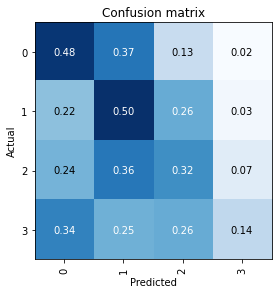

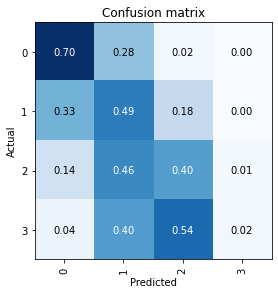

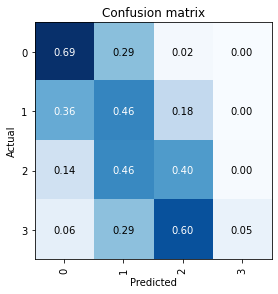

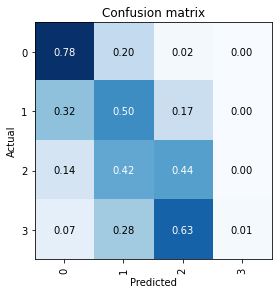

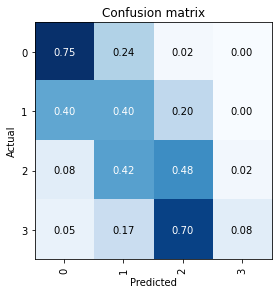

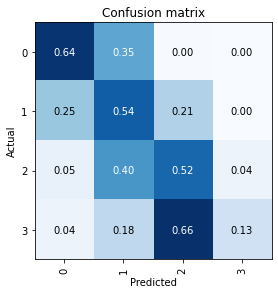

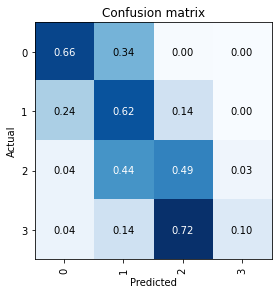

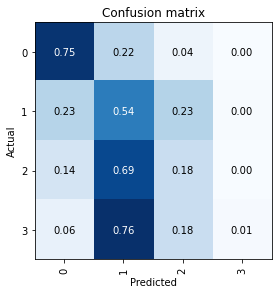

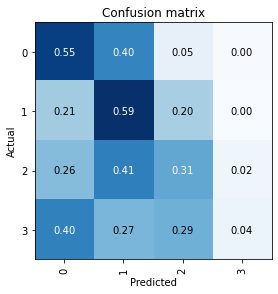

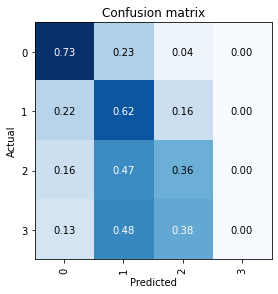

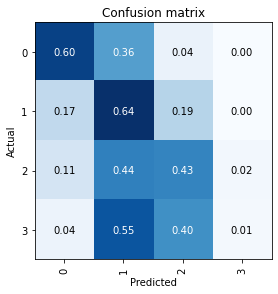

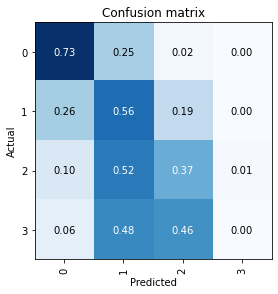

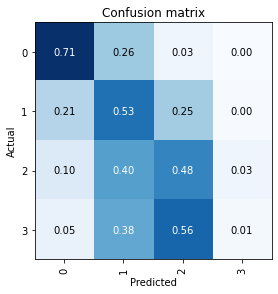

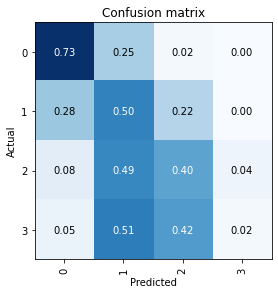

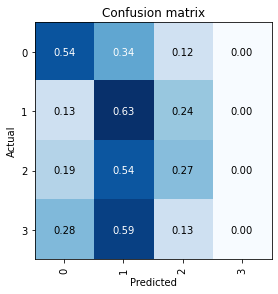

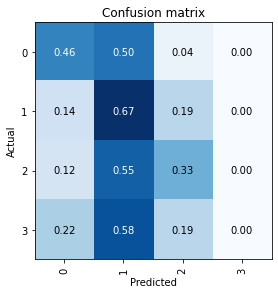

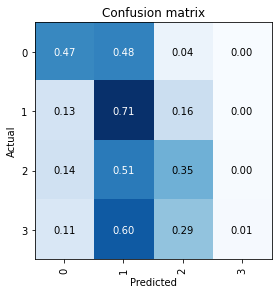

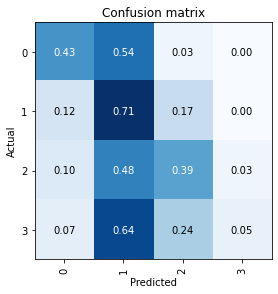

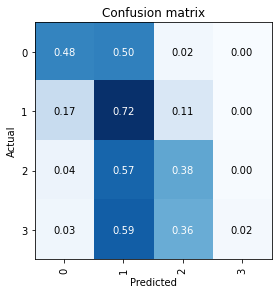

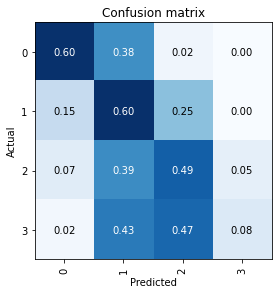

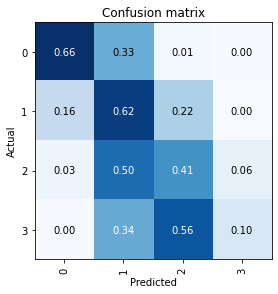

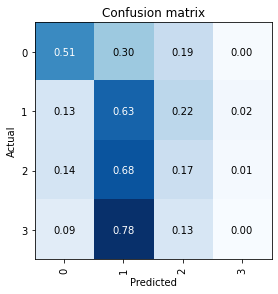

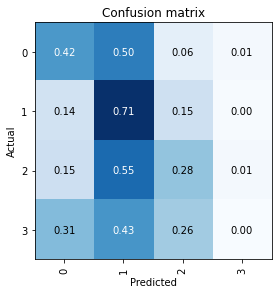

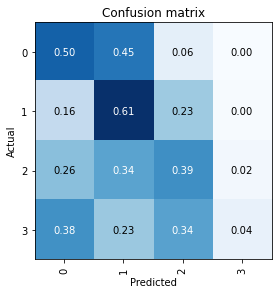

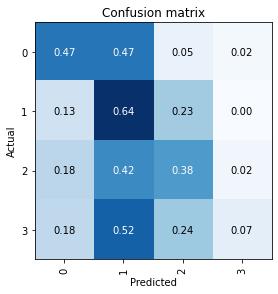

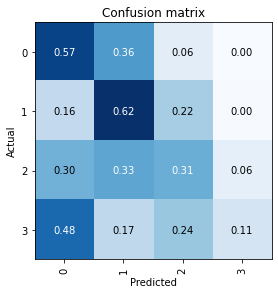

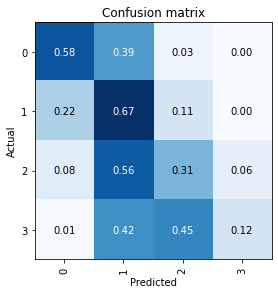

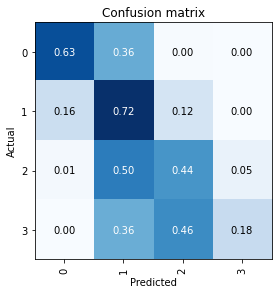

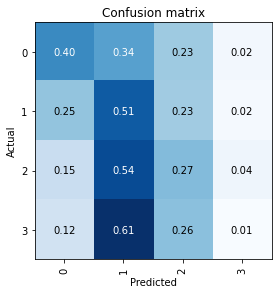

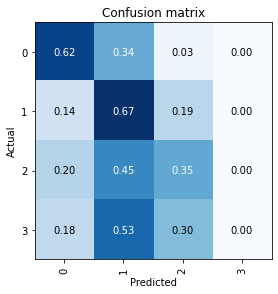

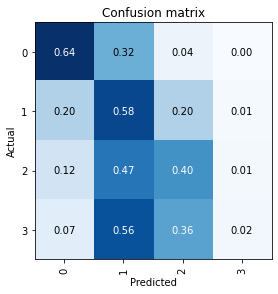

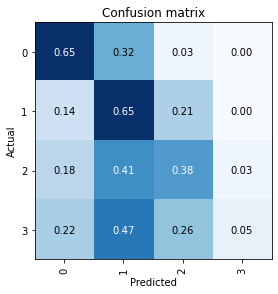

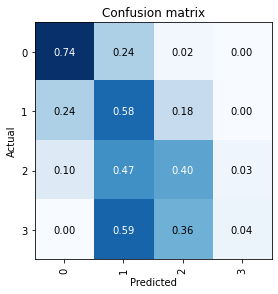

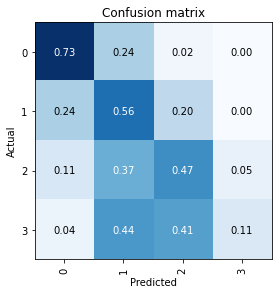

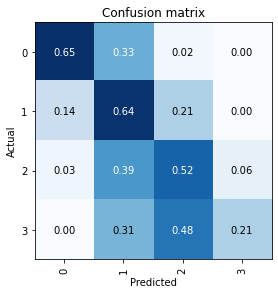

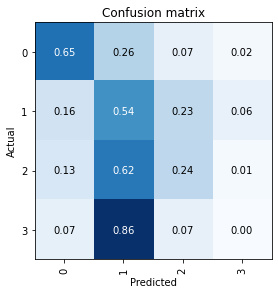

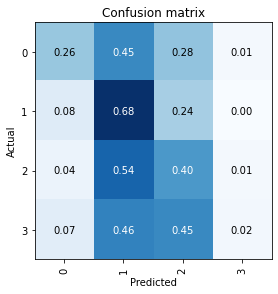

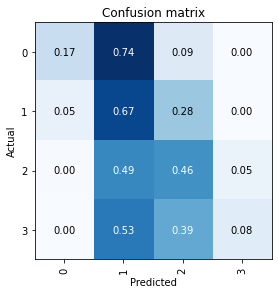

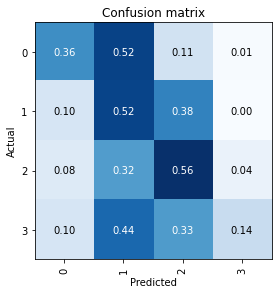

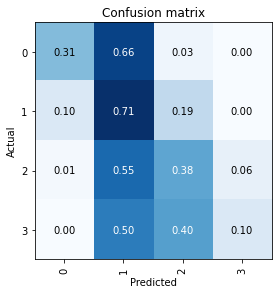

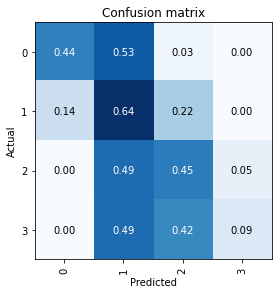

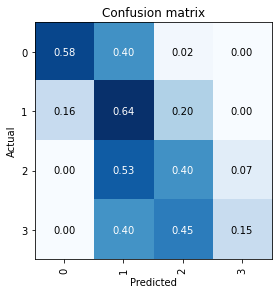

In [38]:
num_epochs = 4
for num_lookback in [7, 30, 60, 90, 120, 180]:
    #print('a')
    for num_f in range(5, num_features, 150):
        #print('b')
        run_experiment(num_lookback, num_f)

On lookback: 30 features: 978 nf: 16 ks: 20 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.863660,4.677555,0.323000,00:34
1,0.665330,1.556510,0.496000,00:18
2,0.510917,1.834854,0.465000,00:18
3,0.405913,1.625965,0.487000,00:18
4,0.306891,1.854633,0.476000,00:18


On lookback: 30 features: 978 nf: 16 ks: 20 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.836380,1.689768,0.476000,00:18
1,0.625381,1.762230,0.485000,00:18
2,0.481117,2.119577,0.441000,00:18
3,0.368228,2.512917,0.403000,00:18
4,0.276397,2.488588,0.447000,00:18


On lookback: 30 features: 978 nf: 16 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.826634,1.626245,0.467000,00:18
1,0.628890,1.867570,0.469000,00:18
2,0.512128,2.496797,0.400000,00:17
3,0.395505,2.214071,0.448000,00:18
4,0.308558,2.379758,0.444000,00:18


On lookback: 30 features: 978 nf: 16 ks: 40 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.786719,1.713300,0.438000,00:18
1,0.599481,1.889904,0.447000,00:18
2,0.451095,1.985927,0.468000,00:17
3,0.373581,2.383122,0.426000,00:17
4,0.269155,2.525944,0.413000,00:18


On lookback: 30 features: 978 nf: 16 ks: 60 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.777365,1.681695,0.371000,00:18
1,0.620240,1.427235,0.495000,00:18
2,0.481089,1.610618,0.437000,00:18
3,0.401912,2.517288,0.460000,00:18
4,0.295710,2.199661,0.456000,00:18


On lookback: 30 features: 978 nf: 16 ks: 60 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.789142,1.796290,0.407000,00:18
1,0.613314,1.973439,0.472000,00:18
2,0.444565,1.953907,0.443000,00:18
3,0.336911,2.295982,0.449000,00:18
4,0.244994,2.464609,0.430000,00:18


On lookback: 30 features: 978 nf: 32 ks: 20 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.822801,1.327461,0.533000,00:18
1,0.647224,1.745953,0.454000,00:18
2,0.522077,2.210528,0.461000,00:18
3,0.417860,2.977200,0.460000,00:18
4,0.329654,2.983744,0.444000,00:18


On lookback: 30 features: 978 nf: 32 ks: 20 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.793722,2.411189,0.383000,00:18
1,0.613389,2.358265,0.448000,00:18
2,0.498354,2.515216,0.432000,00:18
3,0.364164,2.868988,0.449000,00:18
4,0.271452,3.247226,0.426000,00:18


On lookback: 30 features: 978 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.785951,3.057722,0.428000,00:19
1,0.630737,3.088119,0.410000,00:19
2,0.513184,1.830251,0.490000,00:19
3,0.398483,2.332422,0.448000,00:19
4,0.306797,2.288113,0.444000,00:19


On lookback: 30 features: 978 nf: 32 ks: 40 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.791013,2.211588,0.426000,00:18
1,0.618015,2.346676,0.457000,00:18
2,0.476101,1.957467,0.450000,00:18
3,0.360130,2.284115,0.450000,00:18
4,0.251199,2.783603,0.435000,00:18


On lookback: 30 features: 978 nf: 32 ks: 60 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.732664,2.287624,0.486000,00:18
1,0.593749,1.982764,0.438000,00:18
2,0.493911,2.090648,0.421000,00:18
3,0.377310,2.534898,0.417000,00:18
4,0.292216,2.525038,0.443000,00:18


On lookback: 30 features: 978 nf: 32 ks: 60 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.756121,3.479839,0.392000,00:18
1,0.587594,1.797900,0.453000,00:18
2,0.459001,2.170256,0.427000,00:18
3,0.350221,2.867285,0.402000,00:18
4,0.236984,2.899544,0.401000,00:18


On lookback: 30 features: 978 nf: 64 ks: 20 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.819623,5.112871,0.331000,00:19
1,0.652700,2.145219,0.449000,00:18
2,0.533185,2.092911,0.448000,00:18
3,0.412173,2.507824,0.441000,00:18
4,0.315338,2.635091,0.446000,00:18


On lookback: 30 features: 978 nf: 64 ks: 20 bottleneck: False


epoch,train_loss,valid_loss,accuracy,time
0,0.815353,2.935001,0.396000,00:18
1,0.621850,3.875755,0.453000,00:18
2,0.500677,3.117733,0.428000,00:18
3,0.398529,3.815664,0.412000,00:18
4,0.299231,3.864106,0.441000,00:18


On lookback: 30 features: 978 nf: 64 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.772679,2.812378,0.445000,00:18
1,0.642908,1.638704,0.505000,00:18
2,0.502616,2.182477,0.458000,00:18
3,0.380732,2.348400,0.416000,00:18
4,0.296869,2.451852,0.450000,00:18


On lookback: 30 features: 978 nf: 64 ks: 40 bottleneck: False


RuntimeError: CUDA out of memory. Tried to allocate 4.07 GiB (GPU 0; 10.91 GiB total capacity; 153.99 MiB already allocated; 4.08 GiB free; 2.51 GiB reserved in total by PyTorch)

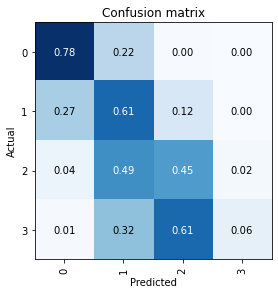

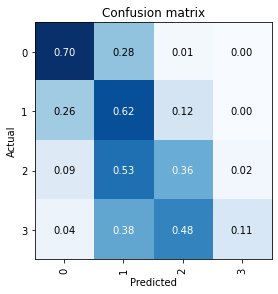

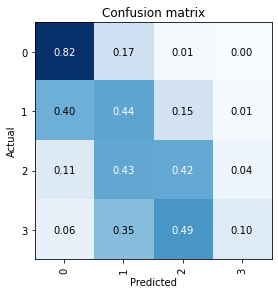

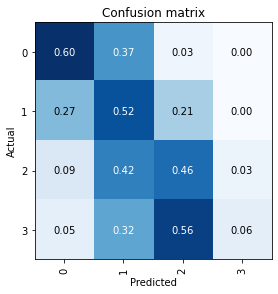

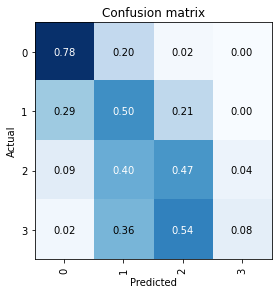

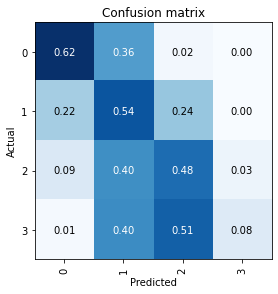

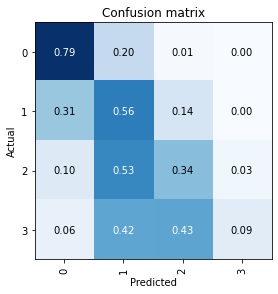

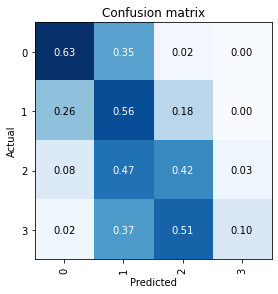

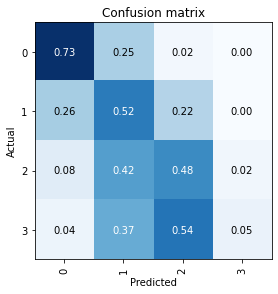

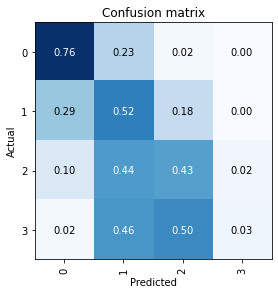

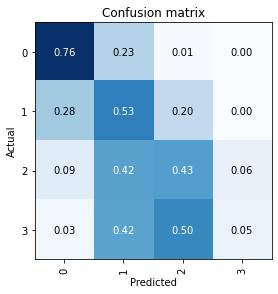

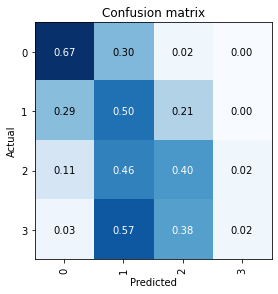

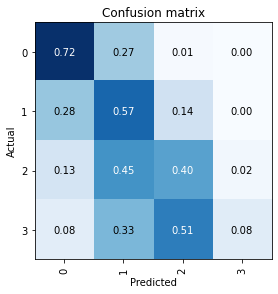

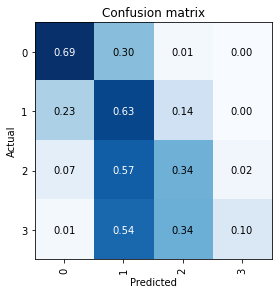

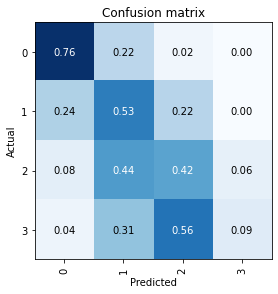

In [42]:
for nf in [16, 32, 64]:
    for ks in [20, 40, 60]:
        for bottleneck in [True, False]:
            run_experiment(30, num_features, nf=nf, ks=ks, bottleneck=bottleneck)

On lookback: 7 features: 755


epoch,train_loss,valid_loss,accuracy,time
0,0.762504,1.189389,0.511000,00:15
1,0.524253,1.380878,0.505000,00:14


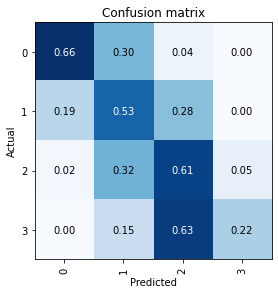

In [57]:
num_epochs = 2
l = run_experiment(7, 755, return_learner=True)

On lookback: 7 features: 755 nf: 32 ks: 20 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,0.727729,1.103672,0.506000,00:14
1,0.531222,1.216105,0.497000,00:14


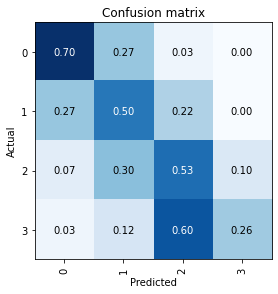

In [36]:
num_epochs = 2
l = run_experiment(7, 755, ks=20, nf=32, return_learner=True)

In [38]:
num_features

978

In [39]:
num_epochs = 2
l = run_experiment(180, num_features, return_learner=True)

On lookback: 180 features: 978 nf: 32 ks: 40 bottleneck: True


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.000000,00:20
1,nan,nan,0.000000,00:19


<ipython-input-32-b7beef3bc8be>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [33]:
l.one_batch()[0].cpu().data.shape

torch.Size([64, 978, 7])

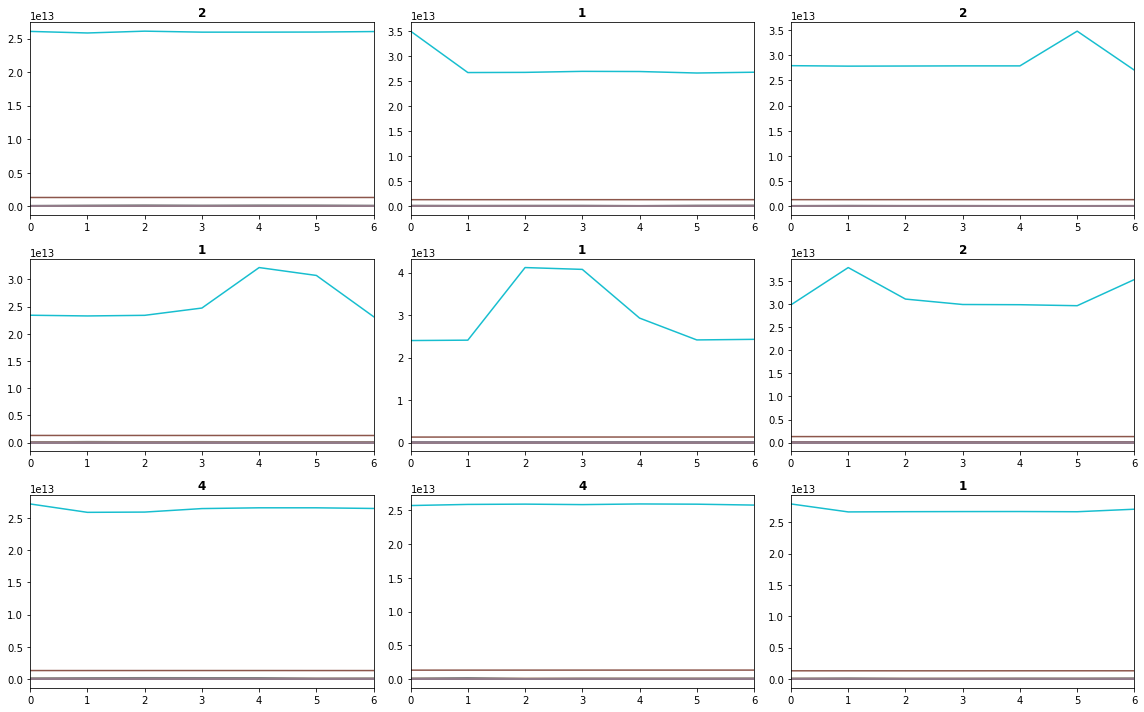

In [34]:
l.valid.show_batch()

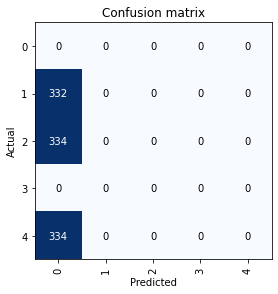

In [37]:
interp = ClassificationInterpretation.from_learner(l)
    
conf_matrix = interp.plot_confusion_matrix()